In [543]:
import numpy as np
import pandas as pd
import smogn
import seaborn
import math
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error
from matplotlib.ticker import PercentFormatter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.utils import resample
import scipy
from numpy.fft import fft
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.feature_selection import SelectKBest, chi2
from tsfresh.transformers import FeatureSelector
np.random.seed(8055)

In [628]:
# Loading and processing data
nomed = True
nolab = True
noinfusion = True

discard_dead = False

data = pd.read_csv('los_surv_analysis_dat.csv')
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

labs_tokeep = ['LAB_Hgb', 'LAB_Hct', 'LAB_glucose', 'LAB_platelets x 1000', 'LAB_WBC x 1000']


if (nomed):
    data = data[data.columns.drop(list(data.filter(regex='MED_')))]
if (nolab):
    data = data[data.columns.drop([i for i in list(data.filter(regex='LAB_')) if i not in labs_tokeep])]
if (noinfusion):
    data = data[data.columns.drop(list(data.filter(regex='INF_')))]

if (discard_dead):
    # Drop patients who died
    data = data[data['death'] == False]

# Drop patients with los > 30
data = data[data['los'] <= 30]

los = list(data['los'])

cols_todrop = ['patientunitstayid', 'death', 'Value', 'GCS', 'occurs', 'los']
data = data.drop(columns=cols_todrop)

# Resampling (Trying smoteR but doesn't seem to work)
## https://www.kaggle.com/aleksandradeis/regression-addressing-extreme-rare-cases

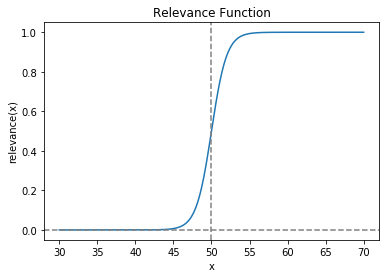

In [23]:
def sigmoid(x):
    return np.exp(x)/(np.exp(x) + 1)

# implement relevance function
# see paper: https://www.researchgate.net/publication/220699419_Utility-Based_Regression
def relevance(x):
    x = np.array(x)
    return sigmoid(x - 50)

# plot relevance function
plt.plot(np.linspace(30, 70, 1000), relevance(np.linspace(30, 70, 1000)))
plt.title('Relevance Function')
plt.xlabel('x')
plt.axhline(y=0, c='gray', linestyle='--')
plt.axvline(x=50, c='gray', linestyle='--')
plt.ylabel('relevance(x)')
plt.show()

In [24]:
# implement SMOTER
# see paper: https://core.ac.uk/download/pdf/29202178.pdf

def get_synth_cases(D, target, o=200, k=3, categorical_col = []):
    '''
    Function to generate the new cases.
    INPUT:
        D - pd.DataFrame with the initial data
        target - string name of the target column in the dataset
        o - oversampling rate
        k - number of nearest neighbors to use for the generation
        categorical_col - list of categorical column names
    OUTPUT:
        new_cases - pd.DataFrame containing new generated cases
    '''
    new_cases = pd.DataFrame(columns = D.columns) # initialize the list of new cases 
    ng = o // 100 # the number of new cases to generate
    for index, case in D.iterrows():
        # find k nearest neighbors of the case
        knn = KNeighborsRegressor(n_neighbors = k+1) # k+1 because the case is the nearest neighbor to itself
        knn.fit(D.drop(columns = [target]).values, D[[target]])
        neighbors = knn.kneighbors(case.drop(labels = [target]).values.reshape(1, -1), return_distance=False).reshape(-1)
        neighbors = np.delete(neighbors, np.where(neighbors == index))
        for i in range(0, ng):
            # randomly choose one of the neighbors
            x = D.iloc[neighbors[np.random.randint(k)]]
            attr = {}                      
            for a in D.columns:
                # skip target column
                if a == target:
                    continue;
                if a in categorical_col:
                    # if categorical then choose randomly one of values
                    if np.random.randint(2) == 0:
                        attr[a] = case[a]
                    else:
                        attr[a] = x[a]
                else:
                    # if continious column
                    diff = case[a] - x[a]
                    attr[a] = case[a] + np.random.randint(2) * diff
            # decide the target column
            new = np.array(list(attr.values()))
            d1 = cosine_similarity(new.reshape(1, -1), case.drop(labels = [target]).values.reshape(1, -1))[0][0]
            d2 = cosine_similarity(new.reshape(1, -1), x.drop(labels = [target]).values.reshape(1, -1))[0][0]
            attr[target] = (d2 * case[target] + d1 * x[target]) / (d1 + d2)
            
            # append the result
            new_cases = new_cases.append(attr,ignore_index = True)
                    
    return new_cases


def SmoteR(D, target, th = 0.999, o = 200, u = 100, k = 3, categorical_col = []):
    '''
    The implementation of SmoteR algorithm:
    https://core.ac.uk/download/pdf/29202178.pdf
    INPUT:
        D - pd.DataFrame - the initial dataset
        target - the name of the target column in the dataset
        th - relevance threshold
        o - oversampling rate
        u - undersampling rate
        k - the number of nearest neighbors
    OUTPUT:
        new_D - the resulting new dataset
    '''
    # median of the target variable
    y_bar = D[target].median()
    
    # find rare cases where target less than median
    rareL = D[(relevance(D[target]) > th) & (D[target] > y_bar)]  
    # generate rare cases for rareL
    new_casesL = get_synth_cases(rareL, target, o, k , categorical_col)
    
    # find rare cases where target greater than median
    rareH = D[(relevance(D[target]) > th) & (D[target] < y_bar)]
    # generate rare cases for rareH
    new_casesH = get_synth_cases(rareH, target, o, k , categorical_col)
       
    new_cases = pd.concat([new_casesL, new_casesH], axis=0)
    
    # undersample norm cases
    norm_cases = D[relevance(D[target]) <= th]
    # get the number of norm cases
    nr_norm = int(len(norm_cases) * u / 100)
    
    norm_cases = norm_cases.sample(min(len(D[relevance(D[target]) <= th]), nr_norm))
    
    # get the resulting dataset
    new_D = pd.concat([new_cases, norm_cases], axis=0)
    
    return new_D

,gcs0,gcs1,gcs2,gcs3,gcs4,hr0,hr1,hr2,hr3,hr4,...,RESP_Pressure to Trigger PS,RESP_TV/kg IBW,RESP_Tidal Volume (set),RESP_Vent Rate,INVASIVE_icp,INVASIVE_pamean,INVASIVE_cvp,INVASIVE_systemicmean,INTAKEOUTPUT_dialysistotal,los
0,21.395486,0.270489,0.140389,-0.132050,-0.127273,-6.178157,-33.565423,14.478607,6.298129,9.661274,...,0.0,1.0,1.0,1.0,1,0,1,1,0.0,6.9319
1,-3.097281,0.190085,-0.071351,-0.041548,0.014309,83.766630,-11.347911,2.104413,1.484555,3.001141,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,6.8625
2,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-10.112928,-10.793130,1.791429,-10.294405,-9.548990,...,0.0,0.0,0.0,0.0,0,0,0,1,0.0,10.0014
3,-3.097281,0.190085,-0.071351,-0.041548,0.014309,55.533416,31.960579,-14.284973,17.194001,-9.265372,...,0.0,0.0,0.0,0.0,0,0,0,1,0.0,6.5340
4,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-59.499693,2.779041,31.849160,0.576734,4.749407,...,0.0,0.0,0.0,0.0,0,0,0,0,1.0,2.5028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1684,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-11.479460,-13.717313,24.588927,9.666096,-4.025659,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,6.0063
1685,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-126.098771,-7.008613,2.239281,-5.131776,0.876373,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,8.2465
1686,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-75.196338,12.732793,11.465426,5.491674,-4.167290,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,7.6736
1687,-3.097281,0.190085,-0.071351,-0.041548,0.014309,55.151090,3.753644,38.058612,-5.158480,2.491408,...,0.0,0.0,0.0,0.0,0,0,0,1,0.0,14.9396


,gcs0,gcs1,gcs2,gcs3,gcs4,hr0,hr1,hr2,hr3,hr4,...,RESP_Pressure to Trigger PS,RESP_TV/kg IBW,RESP_Tidal Volume (set),RESP_Vent Rate,INVASIVE_icp,INVASIVE_pamean,INVASIVE_cvp,INVASIVE_systemicmean,INTAKEOUTPUT_dialysistotal,los
1155,1.801272,0.206165,-0.029003,-0.059649,-0.014008,0.708365,52.845515,-25.277815,-22.516681,-24.236495,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,13.9528
349,12.412750,7.010158,-2.796162,-0.456212,-1.869884,-46.267098,3.329730,2.127164,-0.061251,-0.231034,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,17.8854
725,1.395075,0.955656,-0.714954,-0.710800,0.305143,-84.725346,11.840455,-14.248661,-5.307077,-5.302078,...,0.0,1.0,0.0,0.0,0,0,0,0,0.0,7.8188
0,21.395486,0.270489,0.140389,-0.132050,-0.127273,-6.178157,-33.565423,14.478607,6.298129,9.661274,...,0.0,1.0,1.0,1.0,1,0,1,1,0.0,6.9319
965,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-33.945374,-6.543025,24.146404,-8.356944,-14.595857,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,14.9125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-22.387596,-16.090876,1.132715,23.531955,-8.067481,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,9.2222
22,2.007534,0.145578,-0.307546,-0.083623,-0.258509,182.657615,-19.477419,8.993750,-7.063105,2.716172,...,0.0,1.0,1.0,1.0,0,0,0,1,0.0,21.6590
460,8.159069,-2.675643,-1.947723,0.827494,0.056375,-7.536066,-44.000520,-1.345284,1.687464,-8.383321,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,2.1625
1210,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-2.449106,29.464839,-10.881949,-0.991617,5.451761,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,6.7736


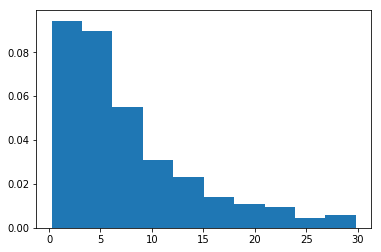

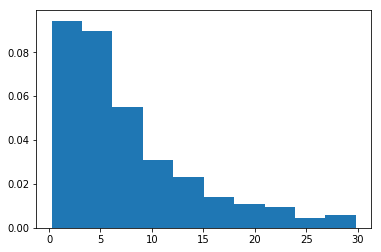

In [59]:
categorical_columns = data.columns[data.columns != 'los']
new = SmoteR(data, target='los', th = 1, o = 1000, u = 1000, k = 10, categorical_col=categorical_columns)

num_bins = 10

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(los, num_bins, density=1)

num_bins = 10

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(list(new['los']), num_bins, density=1)


# Resampling: SMOGN (doesn't work :'))
## https://pypi.org/project/smogn/#:~:text=Description,Noise%20(SMOTER%2DGN).

In [122]:
display(data)

,gcs0,gcs1,gcs2,gcs3,gcs4,hr0,hr1,hr2,hr3,hr4,...,RESP_Pressure to Trigger PS,RESP_TV/kg IBW,RESP_Tidal Volume (set),RESP_Vent Rate,INVASIVE_icp,INVASIVE_pamean,INVASIVE_cvp,INVASIVE_systemicmean,INTAKEOUTPUT_dialysistotal,los
0,21.395486,0.270489,0.140389,-0.132050,-0.127273,-6.178157,-33.565423,14.478607,6.298129,9.661274,...,0.0,1.0,1.0,1.0,1,0,1,1,0.0,6.9319
1,-3.097281,0.190085,-0.071351,-0.041548,0.014309,83.766630,-11.347911,2.104413,1.484555,3.001141,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,6.8625
2,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-10.112928,-10.793130,1.791429,-10.294405,-9.548990,...,0.0,0.0,0.0,0.0,0,0,0,1,0.0,10.0014
3,-3.097281,0.190085,-0.071351,-0.041548,0.014309,55.533416,31.960579,-14.284973,17.194001,-9.265372,...,0.0,0.0,0.0,0.0,0,0,0,1,0.0,6.5340
4,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-59.499693,2.779041,31.849160,0.576734,4.749407,...,0.0,0.0,0.0,0.0,0,0,0,0,1.0,2.5028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1684,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-11.479460,-13.717313,24.588927,9.666096,-4.025659,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,6.0063
1685,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-126.098771,-7.008613,2.239281,-5.131776,0.876373,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,8.2465
1686,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-75.196338,12.732793,11.465426,5.491674,-4.167290,...,0.0,0.0,0.0,0.0,0,0,0,0,0.0,7.6736
1687,-3.097281,0.190085,-0.071351,-0.041548,0.014309,55.151090,3.753644,38.058612,-5.158480,2.491408,...,0.0,0.0,0.0,0.0,0,0,0,1,0.0,14.9396


In [373]:
# ## conduct smogn
# data_smogn = smogn.smoter(
    
#     data = data,  ## pandas dataframe
#     y = 'los',  ## string ('header name')
#     drop_na_col=False
# )

# Modeling

In [629]:
# Binning
bins = [int(i) for i in np.linspace(0, 30, 5)]
print(bins)
y_binned = np.digitize(los, bins)
X_train, X_test, y_train, y_test = train_test_split(data, los, stratify=y_binned, test_size=0.2, random_state=123)
display(X_train)

[0, 7, 15, 22, 30]


,gcs0,gcs1,gcs2,gcs3,gcs4,hr0,hr1,hr2,hr3,hr4,...,RESP_Pressure Support,RESP_Pressure to Trigger PS,RESP_TV/kg IBW,RESP_Tidal Volume (set),RESP_Vent Rate,INVASIVE_icp,INVASIVE_pamean,INVASIVE_cvp,INVASIVE_systemicmean,INTAKEOUTPUT_dialysistotal
1100,-3.097281,0.190085,-0.071351,-0.041548,0.014309,50.470947,-23.783941,-14.850259,-22.329725,9.392614,...,1.0,0.0,1.0,1.0,1.0,0,0,0,0,0.0
1046,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-26.364980,4.030700,-1.448503,-2.969159,4.234895,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0
1529,-3.097281,0.190085,-0.071351,-0.041548,0.014309,76.701715,-16.932671,3.460913,-10.564194,-3.781033,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0
1201,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-51.052586,-15.000600,-15.804273,10.572023,1.843871,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0
1344,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-29.398751,-54.534270,-39.366261,12.991595,4.517994,...,0.0,0.0,1.0,1.0,1.0,0,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-67.104022,14.569649,10.599453,-4.761960,-3.053028,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0
1587,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-22.355833,-24.737784,5.759124,25.870928,-3.999338,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0
1425,16.496932,0.254408,0.098041,-0.113950,-0.098957,94.174511,-7.214582,-10.969889,4.710999,0.393702,...,1.0,0.0,1.0,1.0,0.0,0,0,0,1,0.0
1506,-3.097281,0.190085,-0.071351,-0.041548,0.014309,-19.628730,-57.515114,-0.431601,-1.643178,-3.747216,...,0.0,0.0,1.0,0.0,0.0,0,0,0,1,0.0


In [630]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 2, alpha = 100, n_estimators = 10)

X_train_norm = preprocessing.normalize(X_train)
X_test_norm = preprocessing.normalize(X_test)
xg_reg.fit(X_train_norm,y_train)

preds = xg_reg.predict(X_test_norm)

In [631]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 6.566424


In [632]:
# Cross Validation
data_dmatrix = xgb.DMatrix(data=preprocessing.normalize(data),label=los)
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 2, 'alpha': 100}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

display(cv_results)
print((cv_results["test-rmse-mean"]).tail(1))

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,9.010243,0.142935,9.020151,0.315046
1,8.538246,0.141649,8.567480,0.321458
2,8.134881,0.136233,8.170541,0.321904
3,7.783342,0.128513,7.833808,0.330565
4,7.485724,0.119758,7.550527,0.321705
5,7.231019,0.120000,7.313196,0.314070
6,7.008960,0.121651,7.106631,0.307854
7,6.812886,0.108385,6.911872,0.308006
8,6.649092,0.107051,6.764262,0.297145
9,6.503564,0.102970,6.623321,0.288531


49    5.78939
Name: test-rmse-mean, dtype: float64


In [662]:
# select features using threshold
numfeat = 40
# for thresh in [0.05, -np.inf]:

train_rmses = []
test_rmses = []
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(data, los, stratify=y_binned, test_size=0.2)
    for thresh in [-np.inf]:
        selection = SelectFromModel(xg_reg, threshold=thresh, prefit=True, max_features=numfeat)
        feature_idx = selection.get_support()
        feature_name = X_train.columns[feature_idx]
#         print(feature_name)
        select_X_train = selection.transform(X_train)
        
        X_train_norm = preprocessing.normalize(select_X_train)

        # train model
        selection_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                        max_depth = 2, alpha = 100, n_estimators = 100)
        selection_model.fit(X_train_norm,y_train)

        # eval model
        select_X_test = selection.transform(X_test)
        X_test_norm = preprocessing.normalize(select_X_test)
        y_pred = selection_model.predict(X_test_norm)
        y_train_pred = selection_model.predict(X_train_norm)

        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        train_rmses.append(train_rmse)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        test_rmses.append(rmse)
        print("Train RMSE: %f" % (train_rmse))
        print("Test RMSE: %f" % (rmse))

Train RMSE: 5.201392
Test RMSE: 5.656365
Train RMSE: 5.254442
Test RMSE: 5.523857
Train RMSE: 5.249997
Test RMSE: 5.435537
Train RMSE: 5.263615
Test RMSE: 5.334892
Train RMSE: 5.165778
Test RMSE: 5.768734
Train RMSE: 5.227967
Test RMSE: 5.582633
Train RMSE: 5.182728
Test RMSE: 5.622666
Train RMSE: 5.226838
Test RMSE: 5.481898
Train RMSE: 5.098077
Test RMSE: 6.005858
Train RMSE: 5.198933
Test RMSE: 5.714819
Train RMSE: 5.099156
Test RMSE: 5.933907
Train RMSE: 5.225311
Test RMSE: 5.521777
Train RMSE: 5.132940
Test RMSE: 5.805525
Train RMSE: 5.021029
Test RMSE: 6.200425
Train RMSE: 5.207531
Test RMSE: 5.531697
Train RMSE: 5.118274
Test RMSE: 5.919843
Train RMSE: 5.211570
Test RMSE: 5.624460
Train RMSE: 5.199119
Test RMSE: 5.595238
Train RMSE: 5.118776
Test RMSE: 5.725420
Train RMSE: 5.246323
Test RMSE: 5.435855


In [663]:
print(np.mean(train_rmses))
print(np.mean(test_rmses))

5.18248974962655
5.671070348671926


In [665]:
for f in feature_name:
    print(f)

gcs0
gcs1
gcs2
gcs3
gcs4
hr0
hr1
hr2
hr3
hr4
resp0
resp1
resp2
resp3
resp4
sao20
sao21
sao22
sao23
sao24
NC_verbal
NC_eyes
NC_temp
LAB_Hct
LAB_Hgb
LAB_WBC x 1000
LAB_glucose
LAB_platelets x 1000
DEM_age
DEM_admissionheight
DEM_admissionweight
DEM_gender
AP_sys
AP_dias
AP_bp
RESP_A1: High Exhaled Vt
RESP_PEEP
RESP_Tidal Volume (set)
INVASIVE_icp
INVASIVE_systemicmean


Text(0, 0.5, 'Predicted LOS (days)')

<Figure size 7200x7200 with 0 Axes>

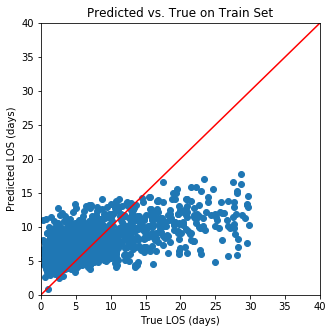

<Figure size 7200x7200 with 0 Axes>

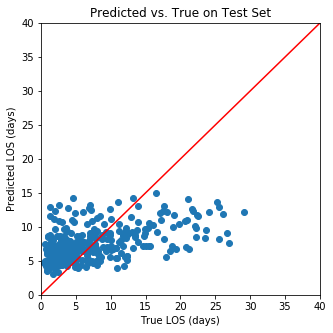

In [666]:
# Plotting predictions against true
xmax = 40
ymax = 40

x = list(range(0,xmax+1))
y = x

plt.figure()
plt.figure(figsize=(5, 5))
plt.plot(y_train, y_train_pred, 'o')
plt.axis([0, xmax, 0, ymax])
plt.plot(x,y, 'r')
plt.title('Predicted vs. True on Train Set')
plt.xlabel('True LOS (days)')
plt.ylabel('Predicted LOS (days)')

plt.figure()
plt.figure(figsize=(5, 5))
plt.plot(y_test, y_pred, 'o')
plt.axis([0, xmax, 0, ymax])
plt.plot(x,y, 'r')
plt.title('Predicted vs. True on Test Set')
plt.xlabel('True LOS (days)')
plt.ylabel('Predicted LOS (days)')

In [667]:
for c in data.columns:
    print(c)

gcs0
gcs1
gcs2
gcs3
gcs4
hr0
hr1
hr2
hr3
hr4
resp0
resp1
resp2
resp3
resp4
sao20
sao21
sao22
sao23
sao24
NC_verbal
NC_eyes
NC_temp
LAB_Hct
LAB_Hgb
LAB_WBC x 1000
LAB_glucose
LAB_platelets x 1000
DEM_age
DEM_admissionheight
DEM_admissionweight
DEM_gender
AP_sys
AP_dias
AP_bp
RESP_A1: High Exhaled Vt
RESP_B1: IPAP
RESP_B2: EPAP
RESP_B3: Est Mask Leak
RESP_CPAP
RESP_Compliance
RESP_ETCO2
RESP_Exhaled MV
RESP_Exhaled TV (machine)
RESP_Exhaled TV (patient)
RESP_FiO2
RESP_Flow Sensitivity
RESP_Humidifier Temp
RESP_LPM O2
RESP_Mean Airway Pressure
RESP_PEEP
RESP_PEEP/CPAP
RESP_Peak Flow
RESP_Peak Insp. Pressure
RESP_Plateau Pressure
RESP_Pressure Control
RESP_Pressure Support
RESP_Pressure to Trigger PS
RESP_TV/kg IBW
RESP_Tidal Volume (set)
RESP_Vent Rate
INVASIVE_icp
INVASIVE_pamean
INVASIVE_cvp
INVASIVE_systemicmean
INTAKEOUTPUT_dialysistotal
